In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [7]:
import numpy as np
# import torch, torchvision
# from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

from copy import deepcopy

In [8]:
from sklearn import svm, preprocessing
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
def get_separability_score(df, label, method='sgd', ret_preds=False):
    # method: sgd or svm
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(df[label])
    
    X_cols = ['dim'+str(i)
              for i in range(768)]
    X = df[X_cols]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    if method=='svm':
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(random_state=0, tol=1e-4))
    elif method=='sgd':
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=5000, tol=1e-4, n_jobs=20))#, loss='log_loss'))
    else:
        raise ValueError()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    if ret_preds:
        preds = clf.predict(X_test)
        return train_score, test_score, preds, y_test
    return train_score, test_score

In [127]:
class ToyBoxEval():
    
    def __init__(self):
        pass

    def get_labels(self, fname):
    #     example fname: truck_30_pivothead_rzminus.mp4
        fnparts = fname.split('.')[0].split('_')
        category = fnparts[0]
        identity = category+fnparts[1]
        trans = fnparts[3]
        return category, identity, trans

    def get_categorylabel(self, fname):
        fnparts = fname.split('.')[0].split('_')
        category = fnparts[0]
        return category

    def get_identitylabel(self, fname):
        fnparts = fname.split('.')[0].split('_')
        category = fnparts[0]
        identity = category+fnparts[1]
        return identity

    def get_translabel(self, fname):
        fnparts = fname.split('.')[0].split('_')
        translabel = fnparts[3]
        return translabel

    def add_labels_to_df(self, df, labels):
        if 'category' in labels:
            df['category'] = df['fnames'].apply(lambda fname: self.get_categorylabel(fname))
        if 'identity' in labels:
            df['identity'] = df['fnames'].apply(lambda fname: self.get_identitylabel(fname))
        if 'transformation' in labels:
            df['transformation'] = df['fnames'].apply(lambda fname: self.get_translabel(fname))
        return df
    
    def fix_fnames(self, df):
        df.iloc[2163,0] = 'giraffe_02_pivothead_rzplus.mp4'
        df.iloc[1851,0]='duck_06_pivothead_rxminus.mp4'
        df.iloc[751,0] = 'car_03_pivothead_rzminus.mp4'
        return df

    def eval_embs(self, fp, method='sgd', ret_preds=False):
        scores = {}

        df = pd.read_csv(fp)

    #     fix 3 filenames. for older files
        df = self.fix_fnames(df)
        df = self.add_labels_to_df(df, ['category', 'identity','transformation'])

    #     if ret_preds
        scores['category'] = get_separability_score(df, 'category', method=method)
    #     scores['identity'] = get_separability_score(df, 'identity', method=method)
        scores['transformation'] = get_separability_score(df, 'transformation', method=method)
        return scores
    
    def proc_fp(self, fp, score_type):
        df = pd.read_csv(fp)
        df = self.fix_fnames(df)
        
        df = self.add_labels_to_df(df, ['category', 'identity','transformation'])
        method='sgd'
        train_score, test_score, preds, targets = get_separability_score(df, score_type, method=method, ret_preds=True)
        return test_score

In [114]:
class SSv2Eval():
    
    def __init__(self, label_path=None):
        if label_path is None:
            label_path = '/N/project/baby_vision_curriculum/benchmarks/ssv2/easy_labels/train_easy10.csv'
        self.labels_df = pd.read_csv(label_path)
        self.labels_df.set_index('fname', inplace=True)

    def get_categorylabel(self, fname):
        return self.labels_df.loc[str(fname)+'.webm', 'label']

    def add_labels_to_df(self, df, labels):
        if 'category' in labels:
            df['category'] = df['fnames'].apply(lambda fname: self.get_categorylabel(fname))
        return df
    
    def proc_fp(self, fp, score_type):
        if score_type!='category':
            raise ValueError
        df = pd.read_csv(fp)
        df = self.add_labels_to_df(df, ['category'])
        method='sgd'
        train_score, test_score, preds, targets = get_separability_score(df, score_type, method=method, ret_preds=True)
        return test_score

In [115]:
def get_traingroups(curr, stage):
    if curr=='dev':
        return 'g0g1g2'[:2*stage]
    elif curr=='adev':
        return 'g2g1g0'[:2*stage]
    else:
        return 'na'
    
def parse_fname(fp):
# embeddings_adev_1_g2_default_0_246.csv'
    parts = Path(fp).stem.split('_')
    prefix, curr, stage, current_gr, cond, fold, seed = parts
    stage=int(stage)
    train_gr = get_traingroups(curr, stage)
    
    tag_dict = {
        'Curriculum':curr,
        'Stage': stage,
        'Condition':cond,
        'Seed': seed,
        'Train Groups': train_gr,
        'data_id': '_'.join([curr, seed, cond])
    }
    return tag_dict

In [132]:
def proc_fp_model(fp, stage, num_ep, iter_per_ep):
    df = pd.read_csv(fp).iloc[:,1:]
    df = edit_epoch(df, stage, iter_per_ep, num_ep)
    tag_dict = parse_fname(fp)
    for tag in tag_dict.keys():
        df[tag] = tag_dict[tag]
    df = df.rename(columns={
    'epoch': 'Epoch',
    'iteration': 'Iteration',
    'train_loss': 'Train Loss',
    'val_loss': 'Validation Loss'
    })
    df['Train Loss Reduction'] = df['Train Loss'].diff(periods=-1)
    df['Validation Loss Reduction'] = df['Validation Loss'].diff(periods=-1)
    return df

def proc_result_folder(root, ds_task, iter_per_stage):
    if ds_task=='ssv2':
        evaluator = SSv2Eval()
        ds_task = 'category'
    elif ds_task=='tb_cat':
        evaluator = ToyBoxEval()
        ds_task = 'category'
    elif ds_task=='tb_trans':
        evaluator = ToyBoxEval()
        ds_task = 'transformation'
    record_list = []
    fpathlist = [emb_root+fname
                for fname in os.listdir(emb_root)
                if Path(emb_root+fname).suffix=='.csv']
    for fp in tqdm(fpathlist):
        record = parse_fname(fp)
        if '141' in fp:
            continue
        record[ds_task] = evaluator.proc_fp(fp, ds_task)
        record['Iteration']=iter_per_stage*record['Stage']
        record_list.append(deepcopy(record))
    df = pd.DataFrame.from_records(record_list)         
    return df

In [133]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul28dev/benchmarks/ssv2/'
# '/N/project/baby_vision_curriculum/trained_models/predictive/v1/jul281/benchmarks/toybox/'

In [136]:
ds_task = 'ssv2'
# 'category'
num_ep,iter_per_ep = 1, 5000
iter_per_stage = num_ep*iter_per_ep

df24 = proc_result_folder(emb_root, ds_task, iter_per_stage)

  0%|                                                     | 0/3 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|█████████████████████████████████████████████| 3/3 [00:25<00:00,  8.59s/it]


In [137]:
df24

,Curriculum,Stage,Condition,Seed,Train Groups,data_id,category,Iteration
0,dev,1,fr6,142,g0,dev_142_fr6,0.611212,5000


In [ ]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/predictive/v1/jul281/benchmarks/toybox/'


ds_task = 'tb_trans' #'tb_cat'#
num_ep,iter_per_ep = 1, 5000
iter_per_stage = num_ep*iter_per_ep

df24tr = proc_result_folder(emb_root, ds_task, iter_per_stage)

In [20]:
df24tr

,Curriculum,Stage,Condition,Seed,Train Groups,data_id,transformation,Iteration
0,adev,1,def2,246,g2,adev_246_def2,0.320675,5000
1,dev,1,def2,246,g0,dev_246_def2,0.325598,5000
2,dev,1,def2,245,g0,dev_245_def2,0.331224,5000
3,adev,1,def2,245,g2,adev_245_def2,0.319269,5000


In [18]:
fp = '/N/project/baby_vision_curriculum/trained_models/predictive/v0/tbembeddings_untrained_1_untrained_ts3nf9_0_261.csv'
ds_task = 'category'
record = parse_fname(fp)
record[ds_task] = proc_fp(fp, ds_task)
record['Iteration']=iter_per_stage*record['Stage']
record

{'Curriculum': 'untrained',
 'Stage': 1,
 'Condition': 'ts3nf9',
 'Seed': '261',
 'Train Groups': None,
 'data_id': 'untrained_261_ts3nf9',
 'category': 0.2819971870604782,
 'Iteration': 2000}

In [ ]:
fp = '/N/project/baby_vision_curriculum/trained_models/predictive/v0/tbembeddings_untrained_1_untrained_ts3nf9_0_261.csv'
ds_task = 'transformation'
record = parse_fname(fp)
record[ds_task] = proc_fp(fp, ds_task)
record['Iteration']=iter_per_stage*record['Stage']
record

arch
Train Groups
g0    0.293601
g2    0.278833
Name: category, dtype: float64
wd
Train Groups
g0    0.316456
g2    0.289381
Name: category, dtype: float64


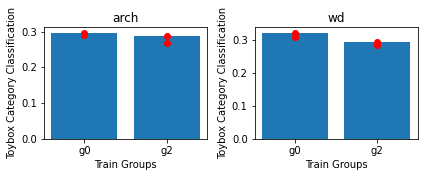

In [28]:
df = df24
# Filter DataFrame for each condition
cond1 = 'arch'
cond2 = 'wd'
task='category'

condition_cond1 = df[df['Condition'] == cond1]
condition_cond2 = df[df['Condition'] == cond2]

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(6, 5/2))

# Plot data for Condition cond1
axes[0].bar(condition_cond1['Train Groups'], condition_cond1[task])
axes[0].set_title(cond1)
axes[0].set_xlabel('Train Groups')
axes[0].set_ylabel('Toybox Category Classification')

axes[0].scatter(condition_cond1['Train Groups'], condition_cond1[task], color='red', label='Data Points')
print(cond1)
print(condition_cond1.groupby('Train Groups')[task].mean())

# Plot data for Condition cond1
axes[1].bar(condition_cond2['Train Groups'], condition_cond2[task])
axes[1].set_title(cond2)
axes[1].set_xlabel('Train Groups')
axes[1].set_ylabel('Toybox Category Classification')
axes[1].scatter(condition_cond2['Train Groups'], condition_cond2[task], color='red', label='Data Points')
print(cond2)
print(condition_cond2.groupby('Train Groups')[task].mean())

# Adjust layout and display the plot
plt.tight_layout()

Train Groups
g0    0.314346
g2    0.342827
Name: transformation, dtype: float64
Train Groups
g0    0.312940
g2    0.321378
Name: transformation, dtype: float64


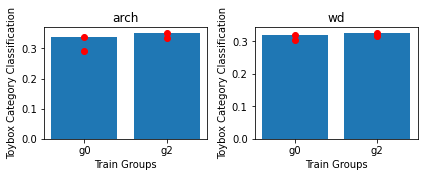

In [29]:
df = df24tr
# Filter DataFrame for each condition
cond1 = 'arch'
cond2 = 'wd'
task='transformation'

condition_cond1 = df[df['Condition'] == cond1]
condition_cond2 = df[df['Condition'] == cond2]

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(6, 5/2))

# Plot data for Condition "default"
axes[0].bar(condition_cond1['Train Groups'], condition_cond1[task])
axes[0].set_title(cond1)
axes[0].set_xlabel('Train Groups')
axes[0].set_ylabel('Toybox Category Classification')

axes[0].scatter(condition_cond1['Train Groups'], condition_cond1[task], color='red', label='Data Points')
print(condition_cond1.groupby('Train Groups')[task].mean())

# Plot data for Condition "crop"
axes[1].bar(condition_cond2['Train Groups'], condition_cond2[task])
axes[1].set_title(cond2)
axes[1].set_xlabel('Train Groups')
axes[1].set_ylabel('Toybox Category Classification')
axes[1].scatter(condition_cond2['Train Groups'], condition_cond2[task], color='red', label='Data Points')
print(condition_cond2.groupby('Train Groups')[task].mean())

# Adjust layout and display the plot
plt.tight_layout()